In [60]:
# load packages
import numpy as np 
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
from itertools import chain
from scipy.optimize import curve_fit

### *Import File to Process*

In [61]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\SSRP_analysis_branch\\Contrast_Response_Functions\\' # set dir - on my computer
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Avilable Files to choose from: {len(d)}')
print(f'Files on hand: {d}')
##############################################
FileN_f1 = d[2] #  data    
print(FileN_f1) 
file_path1 = os.path.join(MainDir, FileN_f1) # join paths and prep 2 load
print( 'Group Imported:', file_path1.split('_')[-5], file_path1.split('_')[-4])
loadData = pkl.load(open(file_path1, 'rb'))
print('Keys Avialable:', loadData.keys())

Avilable Files to choose from: 4
Files on hand: ['SSRP_CntrlGroup_RCA1_CRF_20240627_150221.pkl', 'SSRP_CntrlGroup_RCA2_CRF_20240627_150307.pkl', 'SSRP_ExptGroup_RCA1_CRF_20240627_145808.pkl', 'SSRP_ExptGroup_RCA2_CRF_20240627_150025.pkl']
SSRP_ExptGroup_RCA1_CRF_20240627_145808.pkl
Group Imported: ExptGroup RCA1
Keys Avialable: dict_keys(['F1_Norm_CRF', 'F2_Norm_CRF', 'F1_Diffs', 'F2_Diffs', 'F1_CRF', 'F2_CRF', 'F1_Raw_Diffs', 'F2_Raw_Diffs', 'File_Location_Indicies', 'Subj_Num_Ids'])


### *Set Basic Plotting themes and colors*

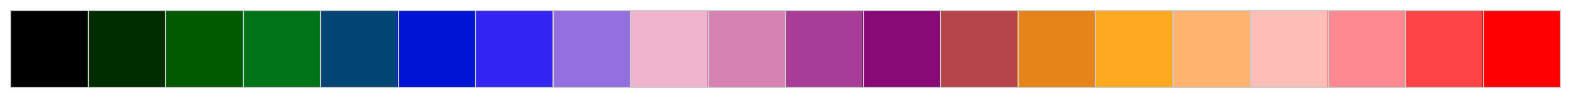

In [62]:
# Define the base colors for blending
base_colors = ['black','green', 'blue', 'pink' ,'purple', 'orange', 'pink','red']
# Number of colors needed in the spectrum
num_colors = 20
fill = sns.blend_palette(base_colors, n_colors=num_colors, as_cmap=False)
sns.palplot(fill)
plt.show()
# color_set = [11,1,8,4]
color_set = [0,12]
custom = {"axes.edgecolor": "black", "grid.linestyle": "dashed", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)

### *Set Fixed Parameters for  Hypoerbolic Ratio / Naka Rushton Fits*

In [63]:
Condition_Label = ['Pot, A+', 'Non-Pot, A+', 'Pot, A-', 'Non-Pot, A-']
crf_label = ['pre','post']
contrast_labs = ['1%','2.5%','6.3%','15.8%','39.8%','100%']
color_set = [3,6,12,13]

ContrastArr = np.array(np.arange(0.0,100,0.1)) # all contrast from 1% - 100% - ~1k data points
ContrastEnd = (ContrastArr.shape[0])
print('length of x array for contrasts: ', ContrastArr.shape)

x1 = np.linspace(0, 100, 6) # all 6 contrasts
x2 = np.linspace(0, 100, ContrastEnd) # all 100 contrasts
contrast_levels = [1,2.5,6.3,15.8,39.8,100]
param_names = ['C50','n','Rmax','b']

length of x array for contrasts:  (1000,)


### *Set Naka-Rushton Functions*

In [64]:
def naka_rushton(C, C50, n, Rmax, b):
    """
    This function models neural responses captured by Contrast Response Functions
     
    C50 (parameter 1) : Contrast level that yields half of max response (contrast %)
    n (parameter 2)   : Determines the curve arc for fitting (small integer)
    Rmax (Parameter 3): Max response elicited (mv)
    b (Parameter 4)   : Starting value (origin)
    """
    return ((Rmax * (( C ** n) / ( C50 ** n + C ** n))) + b)

# def naka_rushton_saturation(C,C50,n,Rmax,b,s):
#     """
#     This function models neural responses captured by Contrast Response Functions with 
#     1 extra parameter to fit supersaturating CRF towards higher contrasts
#     NOTE: The extra parameters means that all 4 values from this fit are DIFFERENT interpretations of original NR funct.
#      C50 (parameter 1) : Contrast level that yields half of max response (contrast %)
#     n (parameter 2)   : Determines the curve arc for fitting (small integer)
#     Rmax (Parameter 3): Max response elicited (mv)
#     b (Parameter 4)   : Starting value (origin)
#     s (Parameter 5)   : saturation index
#     """
#     return ((Rmax * (( C ** n) / ( C50 ** (s*n) + C ** (s*n)))) + b)

### *Functions to organize data for fitting: Saturation index, sorting*

In [65]:
def CombinePrePostResponses(DataIn, Cond2Import, HarmonicIndex):
    # combine data sets in terms of attention and hemifield, sorting ONLY
    Rows = int(len(DataIn))
    Cols = 2
    Data_PrePost_Mat = np.zeros((Rows,Cols,6)) # numsubs x contrasts            
    for combine in range(len(DataIn)):
        Data_PrePost_Mat[combine,:,:] = DataIn[combine][Cond2Import][HarmonicIndex,:,:]
    return Data_PrePost_Mat

In [66]:
# dataIn = PrePostConditionData[0] #[38,2,6]
# # [38, 2]
# PrePost_SaturationValues = np.zeros((int(dataIn.shape[0]),2)) #[subjx xsaturation index values]  # saturation index evaluation
# # [38,2]
# PrePost_SaturationValues_LocInstance = np.zeros((int(dataIn.shape[0]),2)) #[subj x saturation index values] # where saturation occured

# for CRF_SaturationEval in range(2):#range(dataIn.shape[0]): # iterate through all subjects
#     for prepost in range(2): # iterate through pre post crfs

#         crf_data = dataIn[CRF_SaturationEval,prepost] # import 1 crf per iter (6 contrasts)

#         MaxResponseLoc = np.argmax(crf_data) # find where maximum response is
#         MaxResponseVal = crf_data[np.argmax(crf_data)] # find what ax response was given the locaiton

#         # compute saturation index
#         Response_at_100 = crf_data[5] # response at 100% contrast
#         pseudo_C50 = crf_data[3] # reponse at 60% contrast, not 40% or 50% (we dont have 50% :())
#         #SI_response_change = (Response_at_100 - pseudo_C50)/ MaxResponseVal # Saturation Index Computation (Ledgeway et al. 2005) 
#         PrePost_SaturationValues[CRF_SaturationEval,prepost] = (Response_at_100 - pseudo_C50)/ MaxResponseVal #store satruation index 
#         PrePost_SaturationValues_LocInstance[CRF_SaturationEval,prepost] = MaxResponseLoc # store contrast with saturation index  
# print(PrePost_SaturationValues_LocInstance)

In [67]:
def Store_SaturationIndex_Information(dataIn):
    """This function calculates the saturation index for pre and post contrast reponse functions 
        per particpant per condition if it is looped properly.
        Returns: Saturation index calulated for both pre and post CRF's + Location where the maximum reponse was found"""

    PrePost_SaturationValues = np.zeros((int(dataIn.shape[0]),2)) #[subjx xsaturation index values]  # saturation index evaluation
    PrePost_SaturationValues_LocInstance = np.zeros((int(dataIn.shape[0]),2)) #[subj x saturation index values] # where saturation occured
    PrePost_MaxCRF_Val = np.zeros((int(dataIn.shape[0]),2))

    for CRF_SaturationEval in range(dataIn.shape[0]): # iterate through all subjects
        for prepost in range(2): # iterate through pre post crfs
            
            crf_data = dataIn[CRF_SaturationEval,prepost] # import 1 crf per iter

            MaxResponseLoc = np.argmax(crf_data) # find where maximum response is
            MaxResponseVal = crf_data[np.argmax(crf_data)] # find what ax response was given the locaiton

            Response_at_100 = crf_data[5] # response at 100% contrast

            pseudo_C50 = crf_data[3] # reponse at 60% contrast, not 40% or 50% (we dont have 50% :())
            #SI_response_change = (Response_at_100 - pseudo_C50)/ MaxResponseVal # Saturation Index Computation (Ledgeway et al. 2005) 
            PrePost_MaxCRF_Val[CRF_SaturationEval,prepost] = MaxResponseVal
            PrePost_SaturationValues[CRF_SaturationEval,prepost] = (Response_at_100 - pseudo_C50)/ MaxResponseVal #store satruation index 
            PrePost_SaturationValues_LocInstance[CRF_SaturationEval,prepost] = MaxResponseLoc # store contrast with saturation index    

    return PrePost_SaturationValues, PrePost_SaturationValues_LocInstance, PrePost_MaxCRF_Val
############################################################################################################################
# make empty bool to index saturating group and non saturarating crf group for analysis
def GetSaturationIndex_Bool(SaturationValuesIn, CRFs_In): 
    """Since there are many contrast response functions to analyze, here we make a bool for what CRF's displayed
        suspersturation.
        Returns: A binary array to index saturation and +increasing CRFs for pre and post CRFs
        1 == Saturation was present, 0 == Consistent + Increasing CRF
        
        Note: Make sure to remove nan subjs bc they are automitically assigned to SI = 0"""
    Saturation_Bool_PrePost = np.zeros((SaturationValuesIn.shape[0],2)) # bool index, 1 == saturation, 0 = no saturation identified
    #print(Saturation_Bool_PrePost.shape) # [subs (38) , saturation index bool to fill]

    for prepost in range(2):
        for xSubiters in range(CRFs_In.shape[0]):
            SatIndex = SaturationValuesIn[xSubiters,prepost]
            if SatIndex < 0: # if a value is less than 0, append to saturation group 
                #print(f'saturation occured in subject {subjectCRF}')
                Saturation_Bool_PrePost[xSubiters,prepost] = 1
            else: # or else keep as a linear increase crf, as expected
                Saturation_Bool_PrePost[xSubiters,prepost] = 0
    Saturation_Bool_Total = np.sum(Saturation_Bool_PrePost,axis = 1) # returns 0,1,2  | 0 = No saturation, 2 = Saturation on all CRF's

    return Saturation_Bool_PrePost,Saturation_Bool_Total
# ###########################################################################################################################
# def SegmentConditionsPerSaturationgroups(data2divy,bool2Use):
#     Saturation_Group = data2divy[bool2Use > 0,:,:]
#     Linear_Group = data2divy[bool2Use == 0,:,:]

#     dataset = [Saturation_Group,Linear_Group]

#     prepost_mat_out = []
#     prepost_std_mat_out = []

#     for setIn in range(2):
#         CRF_Response = np.zeros((2,6))
#         get_errorbars = np.zeros((2,6))
#         for prepost in range(2):
#             CRF_Response[prepost,:] = np.nanmean(dataset[setIn][:,prepost,:],axis = (0))
#             get_errorbars[prepost,:] = np.nanstd(dataset[setIn][:,prepost,:],axis = 0) / np.sqrt(np.count_nonzero(~np.isnan(dataset[setIn][:,prepost,0])))

#         prepost_mat_out.append(CRF_Response)
#         prepost_std_mat_out.append(get_errorbars)

#     return prepost_mat_out,prepost_std_mat_out,dataset#Saturation_Group, Linear_Group

### *Import Processed, Normalized Contrast Response Function Data and sort*

In [68]:
# indexing certain harmonics ,,,, note sure if this does anything here tho 
Harmonic_Range_To_Include = np.arange(0,2)
NR_Harmonic_Range = Harmonic_Range_To_Include
FirstIndex = int(NR_Harmonic_Range[0])
LastIndex = int(NR_Harmonic_Range [1] + 1)

In [69]:
# subject names and arrays to index attnL and attnR expts
File_Pos = loadData['File_Location_Indicies']
Subj_Ids = loadData['Subj_Num_Ids']
## clean pre post CRF's
F1_Responses = loadData['F1_Norm_CRF']
F2_Responses = loadData['F2_Norm_CRF']

In [70]:
crf_nans = np.zeros((4,2,6))
diff_nans = np.zeros((4,6))
crf_nans[:] = np.nan
diff_nans[:] = np.nan

In [71]:
# sort! 
CRF_IndividualResponses_Sorted = []

for iter in range(len(Subj_Ids)):

    Subj_Title = Subj_Ids[iter] # subject 
    Indiv_File_Locations = File_Pos[iter,:] # import file locations for data
    AttendL_Condition = Indiv_File_Locations[0] # attnL file
    AttendR_Condition = Indiv_File_Locations[1] # attnR file

    # If both locations contain NaNs, replace all data
    if np.isnan(AttendL_Condition) and np.isnan(AttendR_Condition):
        CRF_Set = [crf_nans, crf_nans, crf_nans, crf_nans]
        print('Both AttnL and AttnR files are missing, now replacing all data ...')
        print(Indiv_File_Locations)
    # If the first position contains a NaN, replace with NaN data for F1 and F2
    elif np.isnan(AttendL_Condition):
        print('Attn L file is missing, now replacing ...')
        print(Indiv_File_Locations)
        CRF_Set = [crf_nans, crf_nans, F1_Responses[int(AttendR_Condition)], F2_Responses[int(AttendR_Condition)]]
    # If the second position contains a NaN, replace with NaN data for F1 and F2
    elif np.isnan(AttendR_Condition):
        print('Attn R file is missing, now replacing ...')
        print(Indiv_File_Locations)
        CRF_Set = [F1_Responses[int(AttendL_Condition)], F2_Responses[int(AttendL_Condition)], crf_nans, crf_nans]
    else:
        print('Both AttnL and AttnR files are present.')
        print(Indiv_File_Locations)
        CRF_Set = [F1_Responses[int(AttendL_Condition)], F2_Responses[int(AttendL_Condition)], F1_Responses[int(AttendR_Condition)], F2_Responses[int(AttendR_Condition)]]
        
    CRF_IndividualResponses_Sorted.append(CRF_Set)

Both AttnL and AttnR files are present.
[0. 1.]
Both AttnL and AttnR files are present.
[2. 3.]
Both AttnL and AttnR files are present.
[4. 5.]
Both AttnL and AttnR files are present.
[6. 7.]
Both AttnL and AttnR files are present.
[8. 9.]
Both AttnL and AttnR files are present.
[10. 11.]
Both AttnL and AttnR files are present.
[12. 13.]
Both AttnL and AttnR files are present.
[14. 15.]
Attn R file is missing, now replacing ...
[16. nan]
Both AttnL and AttnR files are present.
[17. 18.]
Both AttnL and AttnR files are missing, now replacing all data ...
[nan nan]
Both AttnL and AttnR files are present.
[21. 22.]
Both AttnL and AttnR files are present.
[23. 24.]
Both AttnL and AttnR files are present.
[25. 26.]
Both AttnL and AttnR files are present.
[27. 28.]
Both AttnL and AttnR files are present.
[29. 30.]
Both AttnL and AttnR files are present.
[31. 32.]
Both AttnL and AttnR files are present.
[33. 34.]
Both AttnL and AttnR files are present.
[35. 36.]
Both AttnL and AttnR files are 

#### *Should have 4 indices, each for : Pot Attn Cong, NonPot Attn Congr, Pot Attn Incong, NonPot Attn Incong*

In [72]:
print(len(CRF_IndividualResponses_Sorted)) # [subject , 4 condtions, harmonic, prepost , contrast]
print(len(CRF_IndividualResponses_Sorted[0])) # 1 subjects perfomrance for boht sessions for each hemisphere
print((CRF_IndividualResponses_Sorted[0][0].shape)) # Harmonic CRF, PrePost Values, Response per sweep

38
4
(4, 2, 6)


### *Combine CRF's into a single array, for a single harmonic at a time*

### *7/11/24 to do: make a for loop to get high harmonic data for fits*

In [73]:
HarmonicValIn = 0

In [74]:
PrePostConditionData = {}
for CondX in range(4):
    PrePostConditionData[CondX] = CombinePrePostResponses(DataIn = CRF_IndividualResponses_Sorted, Cond2Import = CondX, HarmonicIndex = HarmonicValIn)
    print(PrePostConditionData[CondX].shape)

(38, 2, 6)
(38, 2, 6)
(38, 2, 6)
(38, 2, 6)


#### *Based on above, plot saturatation trend across Hemisphere for Attn-Congruent and Incongruent Condition*

In [75]:
Vals = [] 
SaturatingSweep = []
RMaxResponseRecord = []

for CondX in range(4):
    CondX_Vals, CondX_SaturatingSweep, RMaxVals = Store_SaturationIndex_Information(dataIn = PrePostConditionData[CondX])
    Vals.append(CondX_Vals) # saturation index values 
    SaturatingSweep.append(CondX_SaturatingSweep) # position of max repsonse 
    RMaxResponseRecord.append(RMaxVals) # store response at highest contrast 

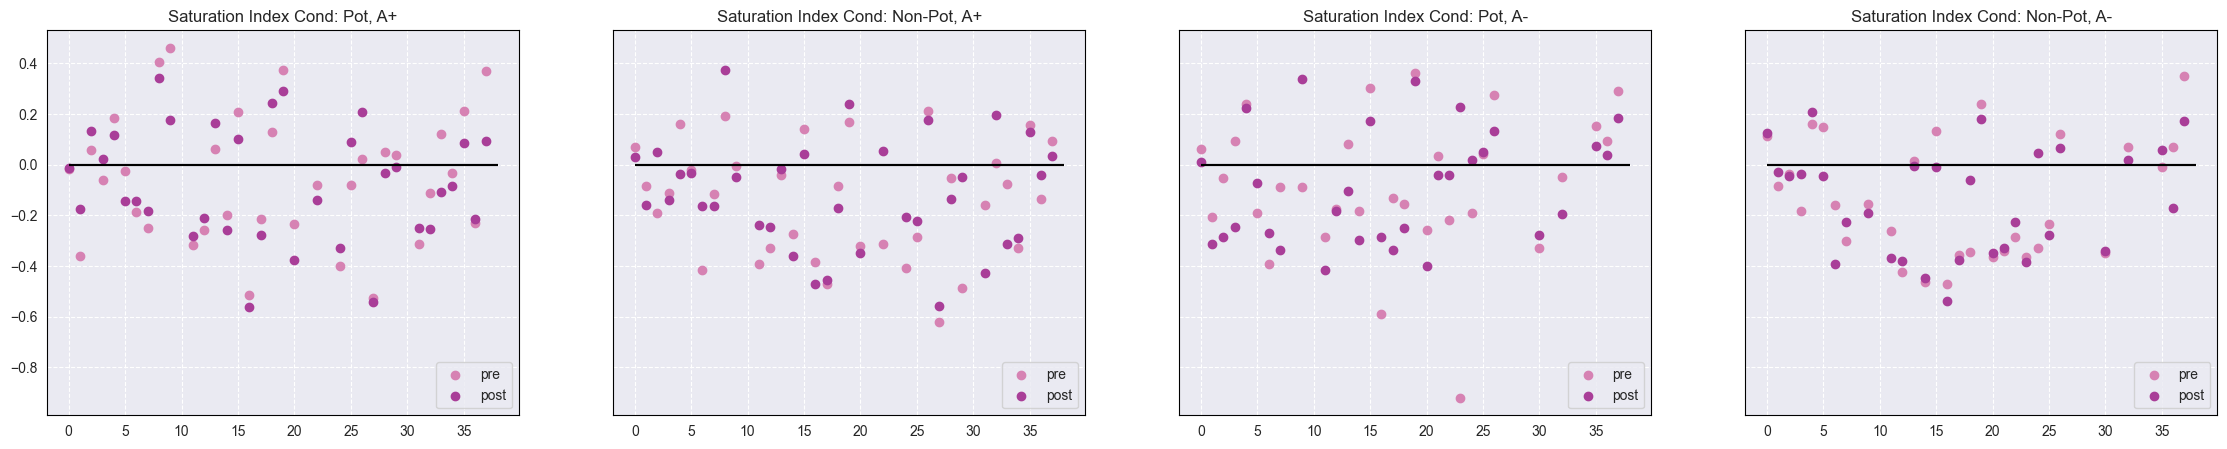

In [76]:
fig,axs = plt.subplots(1,4,figsize = ((28,5)),sharey = True)

for coV in range(4):
    SI_Values_PrePost = np.array(Vals[coV])

    SI_label = ['pre','post']
    for i in range(SI_Values_PrePost.shape[1]):
        axs[coV].scatter(np.arange(0,SI_Values_PrePost.shape[0],1),SI_Values_PrePost[:,i],color = fill[9+i], label = SI_label[i])
        #plt.plot(SI_Values_PrePost[:,i],color = fill[9+i])
        axs[coV].hlines(0,xmin = 0,xmax = int(SI_Values_PrePost.shape[0]), color = fill[0])
        axs[coV].legend(loc = 'lower right')
        axs[coV].set_title(f'Saturation Index Cond: {Condition_Label[coV]}')

In [77]:
# color_s = [0,5]
# for coV in range(4):
#     SI_Values_PrePost = np.array(Vals[coV])

#     fig,axs = plt.subplots(figsize = ((6,3)))
#     for i in range(SI_Values_PrePost.shape[1]):
#         axs.scatter(np.arange(0,SI_Values_PrePost.shape[0],1),SI_Values_PrePost[:,i],color = fill[color_s[i]], label = crf_label[i])
#         #plt.plot(SI_Values_PrePost[:,i],color = fill[color_s[i]])
#         axs.hlines(0,xmin = 0,xmax = int(SI_Values_PrePost.shape[0]), color = fill[0])
#         axs.legend(loc = 'lower right')
#         axs.set_title(f'Saturation Index Cond: {Condition_Label[coV]}')

In [78]:
Saturation_Bool_group = []
Saturation_Counts = [] # wull use this index to identiy saturating CRF groups

for CondX in range(4): 
    sbg, sc = GetSaturationIndex_Bool(SaturationValuesIn = Vals[CondX], CRFs_In= PrePostConditionData[CondX])
    Saturation_Bool_group.append(sbg)
    Saturation_Counts.append(sc)

### *Will use the below array to index between saturating and non saturing responses*

In [79]:
Saturation_Subjs = np.array(Saturation_Counts[0])
print(np.unique((Saturation_Counts[0]),return_counts = True))
print(Saturation_Subjs)

(array([0., 1., 2.]), array([15,  5, 18], dtype=int64))
[2. 2. 0. 1. 0. 2. 2. 2. 0. 0. 0. 2. 2. 0. 2. 0. 2. 2. 0. 0. 2. 0. 2. 0.
 2. 1. 0. 2. 1. 1. 0. 2. 2. 1. 2. 0. 2. 0.]


#### Based on supersaturating reponses, fix responses based on rmax

In [80]:
def SaturationFix_CRF(crf = PrePostConditionData[0],SI = Saturation_Bool_group[0]):

    DataIn = np.array(crf) # pre post contrast repsonse functions 
    SI_In = np.array(SI) # saturation index for pre post

    DataOut = np.zeros_like(DataIn)

    for x in range(DataIn.shape[0]):
        for prepost in range(2):
            if SI_In[x,prepost] == 1:
                crf_rmax = np.max(DataIn[x,prepost])
                crf_rmax_pos = np.argmax(DataIn[x,prepost])
                DataOut[x,prepost,0:crf_rmax_pos] = DataIn[x,prepost,0:crf_rmax_pos]
                DataOut[x,prepost,crf_rmax_pos:] = crf_rmax

            else:
                DataOut[x,prepost,:] = DataIn[x,prepost]

    return DataOut

In [81]:
# def SaturationFix_CRF(crf = PrePostConditionData,SI = Saturation_Bool_group,conditionInterestedIn = x):

#     DataIn = np.array(crf[conditionInterestedIn]) # pre post contrast repsonse functions 
#     SI_In = SI[conditionInterestedIn] # saturation index for pre post


#     sim_crfFuncts = np.zeros_like(DataIn) # fixed crfs with droping tail

#     for SubjIters in range(DataIn.shape[0]):
#         crf_funcs  = DataIn[SubjIters,:,:]
#         SI_Val= SI_In[SubjIters,:]
#         CMax_In = C_Maxresponse[SubjIters,:] # rmax value
#         CMax_pos = c_MaxResponseLoc[SubjIters,:] # rmax location

#         for prepost in range(2):
#             prepost_crf = crf_funcs[prepost]
#             rmax_crf_response = CMax_In[prepost]
#             SI_value = SI_Val[prepost]
#             maxResponse_position = int(CMax_pos[prepost])
#             if SI_value == 1:# if saturation happened .. 
#                 #print(f'cr at 100% will be modified')
#                 maxResponse = prepost_crf[int(rmax_crf_response)] # highest reponse to a contrast 
#                 prepost_crf[maxResponse_position:] = maxResponse # max repsonse  at 100 to be modified
#                 sim_crfFuncts[SubjIters,prepost,:] = prepost_crf
#             else:
#                 sim_crfFuncts[SubjIters,prepost,:] = prepost_crf

#     return  sim_crfFuncts

In [82]:
FixedSaturation_CRF = []
for x in range(4):
    SaturationFixes = SaturationFix_CRF(crf = PrePostConditionData[x],SI = Saturation_Bool_group[x])
    FixedSaturation_CRF.append(SaturationFixes)

##### *Run Original NakaRushton with Non-Saturating, Normalized Contrast Response Functions*

### *NakaRushton Fit Boundaries*

In [83]:
### Model Estimates...based on nothing soild - subject to change 
c50_b = [0,50] # contrast level that yields 50% of max response
n_b = [0,4] # determin curve arc for fitting 
Rmax_b = [0,1] # max response, post-normalization maxrespone = ~ 1.25 / 1.3
b_b = [0,0.5] # starting value, should be around 0-0.9 ish
boundaries=([c50_b[0],n_b[0],Rmax_b[0],b_b[0]], [c50_b[1],n_b[1],Rmax_b[1],b_b[1]]) # Boundary Params for C50, N, Rmax and B
startingGuess = [40,0.1,1,0] # Initial guess for 2f params

In [84]:
# get non-saturating CRFs to fit and derive values from 
nr_Group = []
norm_crf_Group = []

for CondX in range(4):
    #grouped_data = PrePostConditionData[CondX][Saturation_Subjs == 0,:,:] # No Saturation group, SI == 0
    #grouped_data = PrePostConditionData[CondX][Saturation_Subjs > 0,:,:] # Supersaturaton group, SI< 0 
    #grouped_data = PrePostConditionData[CondX] # Supersaturaton group, SI< 0 # ORIGINAL CRFS WITH SATURATION
    norm_crf_data = PrePostConditionData[CondX]
    grouped_data = FixedSaturation_CRF[CondX] # FIXED SATURATION DATA
    nr_Group.append(grouped_data)
    norm_crf_Group.append(norm_crf_data)

In [85]:
print(len(norm_crf_Group))

4


#### *Visualize Original Contrast Resonse Functions*

(38, 2, 6)
(38, 2, 6)
(38, 2, 6)
(38, 2, 6)


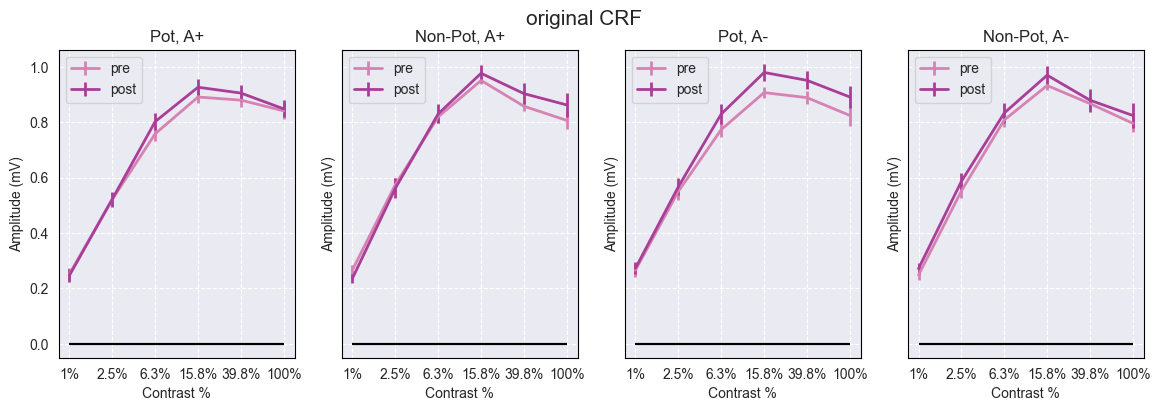

In [86]:
fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)

for x in range(4):
    condition = np.array(norm_crf_Group[x])
    print(condition.shape)
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
    for prepost in range(2):
        prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
        prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
        #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
        axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,label =crf_label[prepost], color = fill[9+prepost], linewidth = 2)
        axs[x].set_title(f'{Condition_Label[x]}')
        axs[x].set_ylabel(f'Amplitude (mV)')
        axs[x].set_xlabel(f'Contrast %')
        axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
        axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
        axs[x].legend()
    plt.suptitle(f'original CRF', fontsize = 15)

### What ryan wants: for every particpant get SI and then use a function like mas to identify max response, and it its not at 100% take repsone at peack and - response 100% 
# do particpants 

#### *Visualize Fixed Satruation Contrast Resposnse Functions*

Text(0.5, 0.98, 'Fixed Saturation CRF')

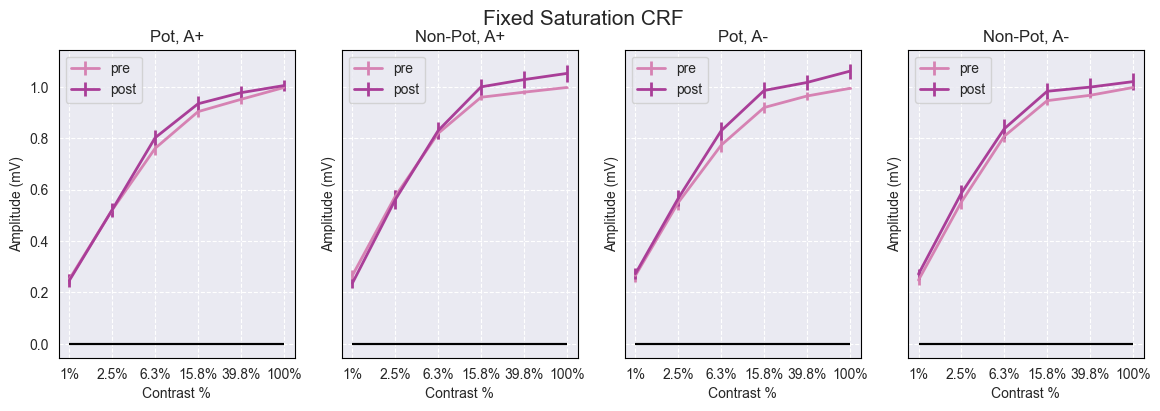

In [87]:
fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)

for x in range(4):

    condition = np.array(FixedSaturation_CRF[x])
    #condition = np.array(nr_Group[x])
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs

    for prepost in range(2):
        prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
        prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
        #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
        axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,label =crf_label[prepost], color = fill[9+prepost], linewidth = 2)
        axs[x].set_title(f'{Condition_Label[x]}')
        axs[x].set_ylabel(f'Amplitude (mV)')
        axs[x].set_xlabel(f'Contrast %')
        axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
        axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
        axs[x].legend()

plt.suptitle(f'Fixed Saturation CRF', fontsize = 15)

#### *to do: 7/12/24| plot pre post differences again*

In [88]:
# dummy data for pre-exisiting nan data (missing files)
emptyMat = np.zeros((1,4))
emptyMat[:] = np.nan

In [89]:
AllCondition_FitParams = []

for nr_group_in in range(4):
    #nr_group_data = np.array(nr_Group[nr_group_in]) # original contrast repsonse functions 
    nr_group_data = np.array(FixedSaturation_CRF[nr_group_in]) # fixed saturation contrast repsonse functions 
    
    Fit_Params = np.zeros((nr_group_data.shape[0],2,4)) # [numsubs x prepost x fit outputs for hyperbolic ratio values]

    for subj in range(nr_group_data.shape[0]):
        for prepost in range(2):
            functs_In = nr_group_data[subj,prepost,:]
            if np.isnan(functs_In).all():
                #print(f'skipping this computation..., data not avilable: {subj,prepost}')
                Fit_Params[subj,prepost,:] = emptyMat
            else: 
                Fit_Params[subj,prepost,:], _ = curve_fit(naka_rushton,contrast_levels,functs_In,p0 = [20,0.05,1,0], bounds = boundaries,nan_policy='omit', method='trf')
    AllCondition_FitParams.append(Fit_Params)

In [90]:
AllCondition_SmoothFits = []

for nr_group_in in range(4):
    nr_group_fitVals = np.array(AllCondition_FitParams[nr_group_in]) # params form curve fit
    SmoothFitsOut = np.zeros((nr_Group[nr_group_in].shape[0],2,int(len(ContrastArr)))) # empty array to make smooth fits

    for subjFitVals in range(nr_group_fitVals.shape[0]):
        for prepost in range(2):
            SmoothFits = np.array(nr_group_fitVals[subjFitVals,prepost,:]) # 4 values 
            SmoothFitsOut[subjFitVals,prepost,:] = naka_rushton(ContrastArr,SmoothFits[0],SmoothFits[1],SmoothFits[2],SmoothFits[3])
    AllCondition_SmoothFits.append(SmoothFitsOut)

In [91]:
crf__loc_vals = np.array(contrast_levels) - 1

In [92]:
# for subject in range(AllCondition_SmoothFits[0].shape[0]):
#     fig,axs = plt.subplots(1,4,figsize = ((16,4)),sharey = True)
#     for vx in range(4):
#         smoothfitsimports = np.array(AllCondition_SmoothFits[vx][subject,:,:])
#         #crfimports = np.array(nr_Group[vx][subject,:,:])
#         crfimports = np.array(FixedSaturation_CRF[vx][subject,:,:])
    
#         nr_fit_values = np.array(AllCondition_FitParams[vx][subject,:,:])
#         for prepost in range(2):
#             axs[vx].plot(x2,smoothfitsimports[prepost,:],color = fill[9+prepost])
#             axs[vx].scatter(contrast_levels, crfimports[prepost,:],color = fill[9+prepost],marker = 'o', linewidths = 1, s = 80,label = f'PRE: C50: {nr_fit_values[prepost,0]:.2f}, n:{nr_fit_values[prepost,1]:.2f},rMax:{nr_fit_values[prepost,2]:.2f}, B:{nr_fit_values[prepost,3]:.2f}')
#             axs[vx].set_title(f'{Condition_Label[vx]}')
#             axs[vx].set_ylabel(f'Amplitude (mV)')
#             axs[vx].set_xlabel(f'Contrast %')
#             axs[vx].hlines(0,xmin = 0,xmax = 100, color = 'black')

#         for x, y in zip(contrast_levels, crfimports[0,:]):
#             axs[vx].vlines(x, ymin=y-0.10, ymax=y+0.10, color=fill[9], linestyle='--', linewidth=1)

#         for x, y in zip(contrast_levels, crfimports[1,:]):
#             axs[vx].vlines(x, ymin=y-0.10, ymax=y+0.10, color=fill[10],linestyle='--', linewidth=1)

#             #legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
#             axs[vx].legend(loc = 'upper right',fontsize = 9,bbox_to_anchor=(1, -0.14))

#### *Visualize AllCondition_FitParams (naka rushton fit values)*

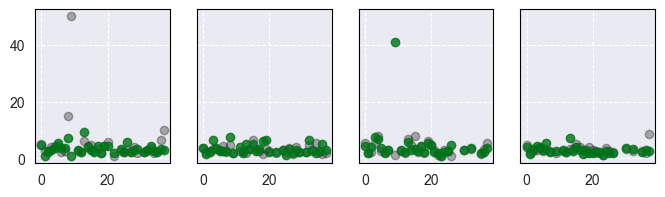

In [93]:
fig,axs = plt.subplots(1,4,figsize = ((8,2)),sharey = True)

for ParamConds in range(4):
    nr_viz = AllCondition_FitParams[ParamConds]
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(nr_viz[:,0,0]))) # get number of subjs
    #print(nr_viz.shape) #[38 x 2 x 4]  = # 3rd Dim = [0] = C50,[1] = n , [2] = rMax, [3] = b
    #print(NumObvs)
    axs[ParamConds].scatter(np.arange(0,int(nr_viz.shape[0]),1),nr_viz[:,0,0], color = fill[0], label = 'Pre C50', alpha = 0.30)
    axs[ParamConds].scatter(np.arange(0,int(nr_viz.shape[0]),1),nr_viz[:,1,0], color = fill[3], label = 'Post C50', alpha = 0.80)

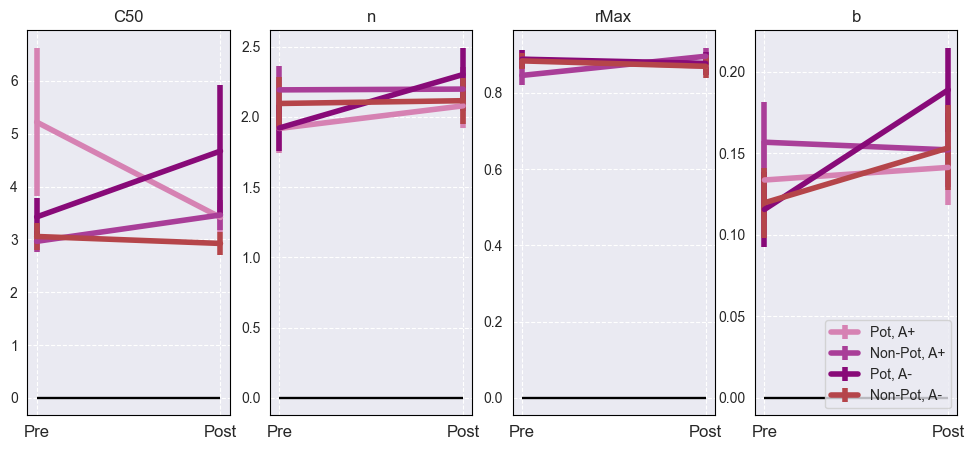

In [94]:
paramVal_title = ['C50','n','rMax','b']
fig,axs = plt.subplots(1,4,figsize = ((12,5)),sharey = False)

for param_Val in range(4):
    for ParamConds in range(4):
        nr_viz = AllCondition_FitParams[ParamConds]
        NumObvs = np.sqrt(np.count_nonzero(~np.isnan(nr_viz[:,0,param_Val]))) # get number of subjs

        paramMeans = np.nanmean(nr_viz[:,:,param_Val],axis = 0)
        paramSTDS = np.nanstd(nr_viz[:,:,param_Val],axis = 0) / NumObvs

        # axs[1.0].errorbar( np.array(paramMeans), yerr = paramSTDS, color ='red', linewidth = 2)
        axs[param_Val].hlines(0,xmin = 0,xmax = 1, color = 'black')
        axs[param_Val].errorbar(np.arange(0,2,1),paramMeans, color = fill[ParamConds+9],yerr = paramSTDS, label = f'{Condition_Label[ParamConds]}', linewidth = 4)
        axs[param_Val].set_xticks(ticks = np.arange(0,2,1),labels = ['Pre','Post'], fontsize= 12)
        axs[param_Val].set_title(f'{paramVal_title[param_Val]}')

axs[3].legend(loc = 'lower right')

#### *Make Naka Rushton Dataframes for MANOVA*
### subtract response differences for each nr value

In [95]:
print(len(AllCondition_FitParams))
print(AllCondition_FitParams[0].shape)

4
(38, 2, 4)


In [96]:
test = AllCondition_FitParams[0][0,:,:]
print(test.shape)
fit_differenceValues = np.subtract(test[1,:],test[0,:])
print(fit_differenceValues)

(2, 4)
[-0.0144329   0.08727411 -0.06626042 -0.01206837]


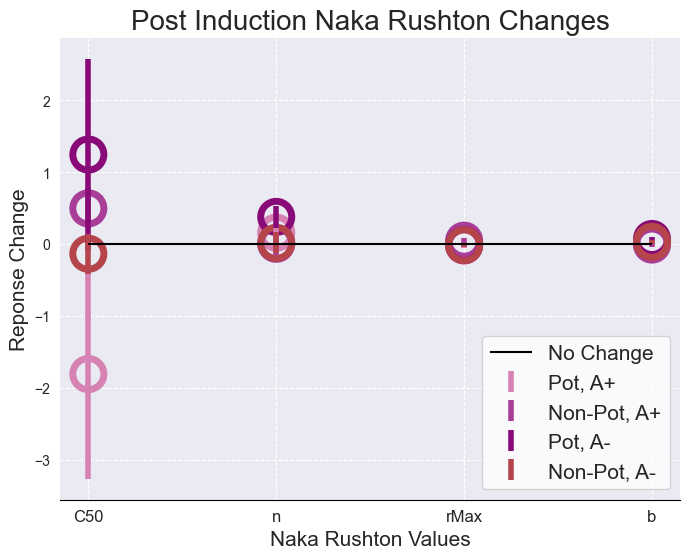

In [97]:
# groupIn = AllCondition_FitParams[3]
# print(groupIn[:,0,:].shape)
fig,axs = plt.subplots(figsize = ((8,6)))
sns.set_style("whitegrid")
sns.despine(left=True)
for xCond_Iters in range(4):
    groupIn = AllCondition_FitParams[xCond_Iters]

    NR_ValuesDiffs = np.subtract(groupIn[:,1,:], groupIn[:,0,:]) # post C50 - pre C50

    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(NR_ValuesDiffs[:,0]))) # get number of subjs

    avgDiff = np.nanmean(NR_ValuesDiffs, axis = 0)
    avgSTD = np.nanstd(NR_ValuesDiffs, axis = 0) / NumObvs

    axs.errorbar(np.arange(0,4,1),avgDiff, color = fill[xCond_Iters+9],yerr = avgSTD, linewidth = 4, ls = 'none',label = Condition_Label[xCond_Iters]) # label = f'{Condition_Label[xCond_Iters]})
    axs.scatter(np.arange(0,4,1),avgDiff, facecolors = 'none', edgecolors = fill[xCond_Iters+9], s = 500, linewidths=5)


axs.set_xticks(ticks = np.arange(0,4,1),labels = ['C50','n', 'rMax', 'b'], fontsize= 12)
axs.hlines(0,xmin = 0,xmax = 3, color = 'black',label = 'No Change')
axs.set_title('Post Induction Naka Rushton Changes', fontsize = 20)
axs.set_ylabel(f'Reponse Change', fontsize = 15)
axs.set_xlabel(f'Naka Rushton Values', fontsize = 15)
axs.legend(loc = 'lower right', fontsize = 15)

#### *Make Dataframes for ANOVA*

In [98]:
attnToArr = [0,0,1,1]
HemifArr = [0,1,0,1]

In [99]:
def NakaRushtonDataFrames( condDataIn, HemiBool,AttnBool,subs = Subj_Ids):
    NakaDataFrames = []
    FitValues_mat= np.zeros((4,7))

    for SubjInfIn in range(int(len(subs))):
        dataIn = condDataIn[SubjInfIn,:]

        FitValues_mat[:,0] = Subj_Ids[SubjInfIn] # subject identification
        FitValues_mat[:,1] = HarmonicValIn # enter hamronic informaiton
        FitValues_mat[:,2] = AttnBool  #attnTo info 
        FitValues_mat[:,3] =  HemiBool #Hemifield info
        FitValues_mat[:,4] =  np.array(np.arange(0,4,1)) # 0 = c50, 1 = n, 2 = -rmax, 3 = b
        FitValues_mat[:,5] = dataIn[0,:] # pre nk paramters 
        FitValues_mat[:,6] = dataIn[1,:] # post nr parameters

        NakaDataFrames.append(FitValues_mat)

    return NakaDataFrames

In [100]:
NakaRushtonConditon_dfs = {}
for conds in range(4):
    NakaRushtonConditon_dfs[conds] = NakaRushtonDataFrames(condDataIn=AllCondition_FitParams[conds],HemiBool=attnToArr[conds],AttnBool=HemifArr[conds],subs=Subj_Ids)
    print(len(NakaRushtonConditon_dfs[conds]))
    #NakaRushtonConditon_dfs.append(nr_dfs)

38
38
38
38


In [101]:
headers = ['sID','Harmonic','attnTowards','hemifield', 'NR_Params','pre','post',]
print(headers)

['sID', 'Harmonic', 'attnTowards', 'hemifield', 'NR_Params', 'pre', 'post']


In [102]:
GoodSubjs = np.ones((int(len(Subj_Ids))))

In [103]:
temp_df_storage = {}

for CombineFrames in range(4):
    GoodSubjMats = [NakaRushtonConditon_dfs[CombineFrames][i] for i in range(len(GoodSubjs)) if GoodSubjs[i] == 1]
    print(len(GoodSubjMats))
    temp_df_storage[CombineFrames] = np.concatenate(GoodSubjMats,axis = 0)

38
38
38
38


In [104]:
arr2list = list(temp_df_storage.values()) # turn array into a list
CombineAllDataFrames = np.concatenate(arr2list,axis = 0) # concatenate the 4 conditon data frames into 1
Add_Headers_2_DF = pd.DataFrame(CombineAllDataFrames, columns = headers) # add headers to mat

#### Store nr value 

In [105]:
Add_Headers_2_DF

,sID,Harmonic,attnTowards,hemifield,NR_Params,pre,post
0,345216.0,0.0,0.0,0.0,0.0,10.158526,2.883750
1,345216.0,0.0,0.0,0.0,1.0,0.818883,1.827537
2,345216.0,0.0,0.0,0.0,2.0,1.000000,0.748749
3,345216.0,0.0,0.0,0.0,3.0,0.049005,0.061626
4,345216.0,0.0,0.0,0.0,0.0,10.158526,2.883750
...,...,...,...,...,...,...,...
603,345216.0,0.0,1.0,1.0,3.0,0.073150,0.020015
604,345216.0,0.0,1.0,1.0,0.0,8.689667,2.703851
605,345216.0,0.0,1.0,1.0,1.0,0.728263,0.579702
606,345216.0,0.0,1.0,1.0,2.0,1.000000,1.000000


In [59]:
print(f'All Data including NaNs: {Add_Headers_2_DF.shape}') # get shape
No_Nans_inDataFrame = Add_Headers_2_DF.dropna(subset=[Add_Headers_2_DF.columns[-1]]) # drop nans from missing files
print(f'All Data after NaN data is removed: {No_Nans_inDataFrame.shape}')

All Data including NaNs: (608, 7)
All Data after NaN data is removed: (608, 7)


In [107]:
FileOutName = 'Subject_ANOVA_DF_ExptGroup_RCA1_2F_Harmonic_NR_Fits'
print(FileOutName)

Subject_ANOVA_DF_ExptGroup_RCA1_2F_Harmonic_NR_Fits


In [109]:
d_frameOut = No_Nans_inDataFrame.astype(np.float64)
print(d_frameOut.shape)

FramesOut = {'CRF_PrePostFit_Values': d_frameOut,
             'Headers': headers}
DataOutDir= 'C:\\plimon\\GitHub_Repos\\SSRP_Analysis\\Proj_DataFrames\\NakaRushton_DFs\\'
os.chdir(DataOutDir)

(608, 7)


In [110]:
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.mat' 
print(FileN)

#scipy.io.savemat(FileN, FramesOut)

Subject_ANOVA_DF_ExptGroup_RCA1_2F_Harmonic_NR_Fits_20240723_105954.mat
